В нашей игре проводился А/В тест. Каждый игрок был распределен в одну из групп (контрольная или тестовая) и получил идентификатор 0 или 1 соответственно. В тесте мы хотели проверить гипотезу о том, что изменения в тестовой группе положительно повлияют на денежные показатели: ARPU, ARPPU и конверсию. Проведите анализ А/В теста. Данные содержат следующие поля:
- geo_country - страна игрока
- test_timestamp - дата, когда игрок попал в тест
- user_revenue - выручка с игрока
- user_payments - количество платежей игрока
- user_id - идентификатор игрока
- test_group - идентификатор группы теста

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(rc={'figure.figsize':(20,10)})

from tqdm.auto import tqdm
from statsmodels.stats.proportion import proportions_ztest

In [2]:
data = pd.read_csv("data.csv", parse_dates=['test_timestamp'])
data.head()

,geo_country,test_timestamp,user_revenue,user_payments,user_id,test_group
0,Russia,2021-05-03 19:06:06.325,NaN,0,6d696b2e-f236-45b1-b770-5530b2a3b3cf,0
1,India,2021-05-04 17:13:35.877,NaN,0,3ae8cd76-14ef-4e47-99c9-637e9260205e,0
2,Russia,2021-05-01 01:56:49.796,1.223728,1,0bf7d591-a052-44a2-97a5-161791fb440d,0
3,Kazakhstan,2021-05-03 04:17:25.337,NaN,0,5f8a3459-e85d-451e-8f93-0c17664c70da,0
4,Switzerland,2021-05-20 10:49:18.064,NaN,0,f2ea93ed-b9c6-4d8b-88d0-7717f8931988,0


Проверим и подготовим данные:

In [3]:
data.shape

(91000, 6)

In [4]:
data.dtypes

geo_country               object
test_timestamp    datetime64[ns]
user_revenue             float64
user_payments              int64
user_id                   object
test_group                 int64
dtype: object

In [5]:
data.isna().sum()

geo_country          18
test_timestamp        0
user_revenue      84268
user_payments         0
user_id               0
test_group            0
dtype: int64

In [6]:
data.user_revenue.fillna(0, inplace=True)

In [7]:
data.query('geo_country.isna()')
# присутствуют записи без привязки к стране

,geo_country,test_timestamp,user_revenue,user_payments,user_id,test_group
4902,NaN,2021-05-02 12:11:40.675,0.0,0,062de72d-e68d-4958-b88e-2a543fbbb855,0
8626,NaN,2021-05-12 19:42:49.208,0.0,0,c810d2ae-9019-4cc0-b679-fe670c5260c4,0
11199,NaN,2021-05-23 19:01:09.719,0.0,0,1e40be1a-53f9-498b-ab78-9428f2add58e,0
16257,NaN,2021-05-01 17:12:02.575,0.0,0,9f9adafe-4a9f-4de9-ada4-8c0e659c81cd,0
19005,NaN,2021-05-09 12:07:41.241,0.0,0,e680ac0e-1597-442b-bcc9-676864f0e1be,0
19637,NaN,2021-05-31 11:15:44.431,0.0,0,ca31453d-1692-4bda-93dd-85e43e5557d9,0
25156,NaN,2021-05-28 18:41:37.086,0.0,0,1fa38c62-170b-4d0e-b13b-53cdf25f3238,1
26030,NaN,2021-05-23 13:00:28.796,0.0,0,d2d25be9-e100-4d82-84fc-6d4c876ce7b7,1
26778,NaN,2021-05-03 13:30:33.213,0.0,0,e941c812-923d-4eb8-9993-e3afddb58e32,1
33186,NaN,2021-05-01 10:14:17.297,0.0,0,f17724c7-ec1e-4bf4-9672-6e68951c3c36,1


In [8]:
data.user_id.nunique()

91000

In [9]:
data['mean_revenue_per_transact'] = data['user_revenue'] / data['user_payments']
data['is_client'] = (data['user_payments'] >= 1).astype(int) #  т.к. могут возникнуть проблемы при агрегации
data.mean_revenue_per_transact.fillna(0, inplace=True)
data.head()

,geo_country,test_timestamp,user_revenue,user_payments,user_id,test_group,mean_revenue_per_transact,is_client
0,Russia,2021-05-03 19:06:06.325,0.000000,0,6d696b2e-f236-45b1-b770-5530b2a3b3cf,0,0.000000,0
1,India,2021-05-04 17:13:35.877,0.000000,0,3ae8cd76-14ef-4e47-99c9-637e9260205e,0,0.000000,0
2,Russia,2021-05-01 01:56:49.796,1.223728,1,0bf7d591-a052-44a2-97a5-161791fb440d,0,1.223728,1
3,Kazakhstan,2021-05-03 04:17:25.337,0.000000,0,5f8a3459-e85d-451e-8f93-0c17664c70da,0,0.000000,0
4,Switzerland,2021-05-20 10:49:18.064,0.000000,0,f2ea93ed-b9c6-4d8b-88d0-7717f8931988,0,0.000000,0


#### Рассчитаем ключевые метрики

In [10]:
# подготовим данные и соберем полученную информацию в таблицу для наглядности

def get_metrics(df):
    control = data.query('test_group == 0')
    test = data.query('test_group == 1')

    # количество пользователей в группах
    users_quantity_control = control.shape[0]
    users_quantity_test = test.shape[0]

    # выручка
    total_user_revenue_control =  control.user_revenue.sum()
    total_user_revenue_test =  test.user_revenue.sum()

    # количество покупок в группах
    checks_control_quantity = control.query('user_revenue > 0').shape[0]
    checks_test_quantity = test.query('user_revenue > 0').shape[0]

    # количество клиентов в группах
    clients_control_quantity = control.query('is_client == 1').user_id.nunique()
    clients_test_quantity = test.query('is_client == 1').user_id.nunique()

    # конверсия в покупателя
    cr_control = round(clients_control_quantity / users_quantity_control * 100, 2)
    cr_test = round(clients_test_quantity / users_quantity_test * 100 , 2)

    # ARPU
    arpu_control = round(control.user_revenue.sum() / control.shape[0], 6)
    arpu_test = round(test.user_revenue.sum() / test.shape[0], 6)

    # ARPPU
    arppu_control = round(control.user_revenue.sum() / clients_control_quantity, 6)
    arppu_test = round(test.user_revenue.sum() / clients_test_quantity, 6)

    # Средний чек
    avg_check_control = round(np.mean(control.query('user_revenue > 0').user_revenue / control.user_payments), 6)
    avg_check_test = round(np.mean(test.query('user_revenue > 0').user_revenue / test.user_payments), 6)

    # коэффициент повторных покупок
    rep_purch_control = round(control.query('user_revenue > 0').user_payments.mean(), 2)
    rep_purch_test = round(test.query('user_revenue > 0').user_payments.mean(), 2)

    metrics = pd.DataFrame({'group': ["control", "test"],
                            'users': [users_quantity_control, users_quantity_test],
                            'clients': [clients_control_quantity, clients_test_quantity],
                            'total_user_revenue': [total_user_revenue_control, total_user_revenue_test],
                            'CR': [cr_control, cr_test],
                            'arpu': [arpu_control, arpu_test],
                            'arppu': [arppu_control, arppu_test],
                            'avg_check': [avg_check_control, avg_check_test],
                            'rep_purch': [rep_purch_control, rep_purch_test]}
                              )

    metrics = metrics.set_index("group").T

    metrics['diff'] = metrics['test'] - metrics['control']
    metrics['percent_diff'] = round(metrics['diff'] / metrics['control'] * 100, 2)
    return metrics

In [11]:
metrics_by_groups = get_metrics(data)
metrics_by_groups

group,control,test,diff,percent_diff
users,45400.000000,45600.000000,200.000000,0.44
clients,3489.000000,3243.000000,-246.000000,-7.05
total_user_revenue,17001.593107,16090.426997,-911.166110,-5.36
CR,7.690000,7.110000,-0.580000,-7.54
arpu,0.374484,0.352860,-0.021624,-5.77
arppu,4.872913,4.961587,0.088674,1.82
avg_check,1.412182,1.452366,0.040184,2.85
rep_purch,3.510000,3.420000,-0.090000,-2.56


- Суммарная выручка в тестовой группе меньше, чем в контрольной на 5.36%;
- При этом конверсия в платеж тестовой группы пользователей снизилась на 7.54% относительно контрольной;
- ARPU в тестовой группе ниже на 5.77%;
- ARPPU в тестовой группе превосходит аналогичный показатель в контрольной - разница в 1.82%;
- Cредний чек в тестовой группе дороже на 2.85%;
- Коэффициент повторных покупок снизился на 2.56%.

Создадим датафрейм c метриками по дням для каждой страны:

In [12]:
data.test_timestamp = pd.to_datetime(data.test_timestamp.dt.date)

In [13]:
revenue_by_date = (
    data
    .groupby(['test_timestamp', 'test_group', 'geo_country'], as_index=False)
    .agg({'user_id':'nunique', 'is_client':'sum', 'user_revenue':'sum'})
        )
revenue_by_date.columns = ['day', 'group', 'country', 'users', 'clients', 'total_revenue']

In [14]:
revenue_by_date['CR'] = revenue_by_date['clients'] / revenue_by_date['users']
revenue_by_date['ARPU'] = revenue_by_date['total_revenue'] / revenue_by_date['users']
revenue_by_date['ARPPU'] = revenue_by_date['total_revenue'] / revenue_by_date['clients']
revenue_by_date['ARPPU'].fillna(0, inplace=True)

In [15]:
revenue_by_date.sample(5)

,day,group,country,users,clients,total_revenue,CR,ARPU,ARPPU
1229,2021-05-06,0,Honduras,2,0,0.000000,0.000000,0.000000,0.000000
4001,2021-05-22,0,Australia,14,1,1.420154,0.071429,0.101440,1.420154
3799,2021-05-20,1,Denmark,3,1,3.419184,0.333333,1.139728,3.419184
1139,2021-05-05,1,Japan,66,4,17.312633,0.060606,0.262313,4.328158
2525,2021-05-13,0,Austria,1,0,0.000000,0.000000,0.000000,0.000000


In [16]:
revenue_by_date.query('group == 0').shape[0]

2898

In [17]:
revenue_by_date.query('group == 1').shape[0]

2843

Построим графики, позволяющие оценить изменение показателей выручки и посещений в течение периода:

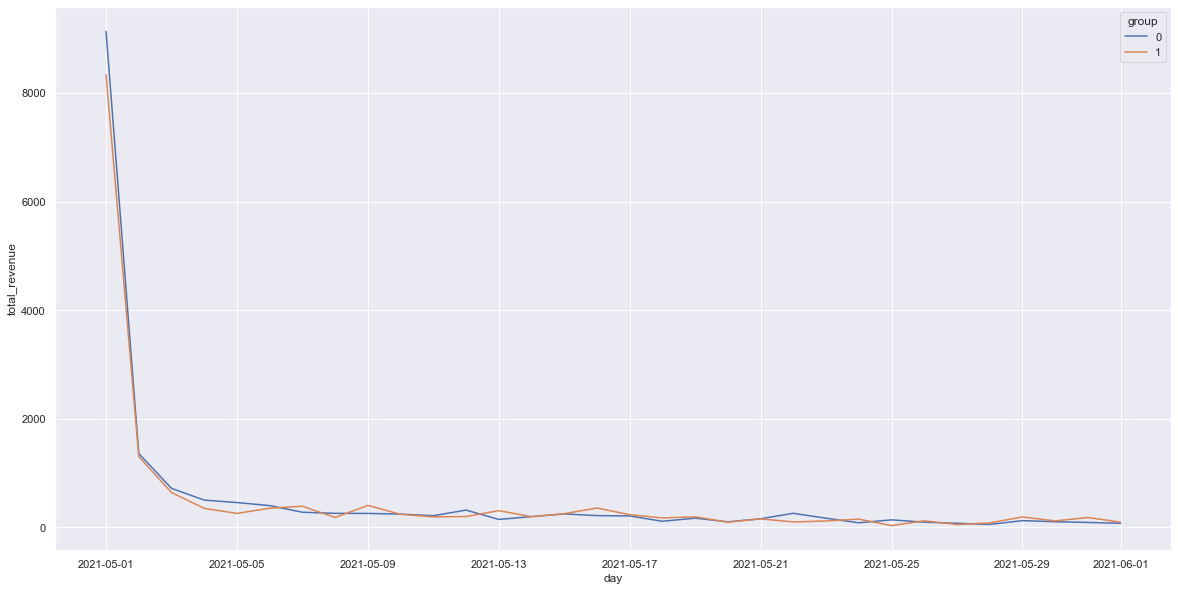

In [18]:
total_revenue_by_day = sns.lineplot(data=revenue_by_date.groupby(['day', 'group']).agg({'total_revenue':'sum'}),
                                    x='day',
                                    y='total_revenue',
                                    hue='group'
                                    )

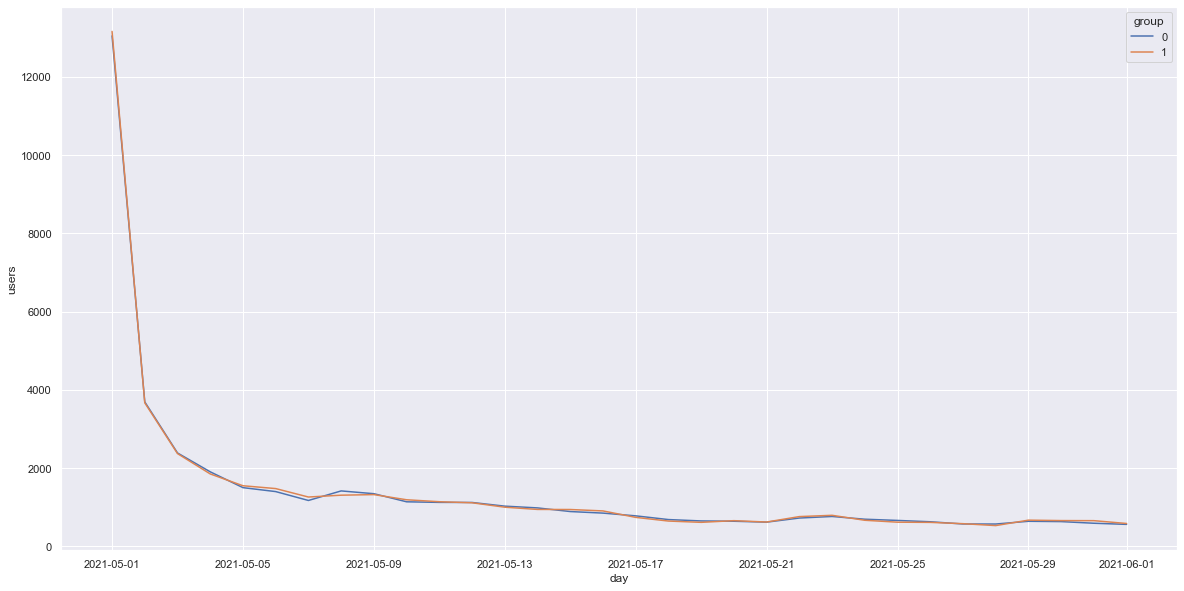

In [19]:
total_users_by_day = sns.lineplot(data=revenue_by_date.groupby(['day', 'group']).agg({'users':'sum'}),
                                  x='day',
                                  y='users',
                                  hue='group'
                                 )

#### Промежуточный итог (рассуждения):
Наблюдается резкое снижение количества пользователей и суммарной выручки в период с 01.05 по 03.05 (чуть менее выражено - до 5.05) в контрольной и тестовой группах.
Было бы полезно проанализировать данные за предшествующий период, чтобы получить представление о возможных причинах такого поведения и понять, с чем мы имеем дело - например, появилась проблема с доступом к приложению на определенной платформе или мы наблюдаем прогнозируемое снижение посещаемости после остановки рекламных кампаний или окончания какого-либо всеобщего внутриигрового события. На основе выводов можно было бы судить о достоверности полученных в ходе AB-теста результатах или корректности его проведения в таких условиях.

Выберем сценарий, что AB-тест прошел по плану.

Перед воспроизведением A/B-теста проверим распределения user_revenue на нормальность тестом Шапиро-Уилка.:

In [20]:
control = data.query('test_group == 0')
test = data.query('test_group == 1')

ShapiroResult(statistic=0.12578243017196655, pvalue=0.0)
2.8038017214413613


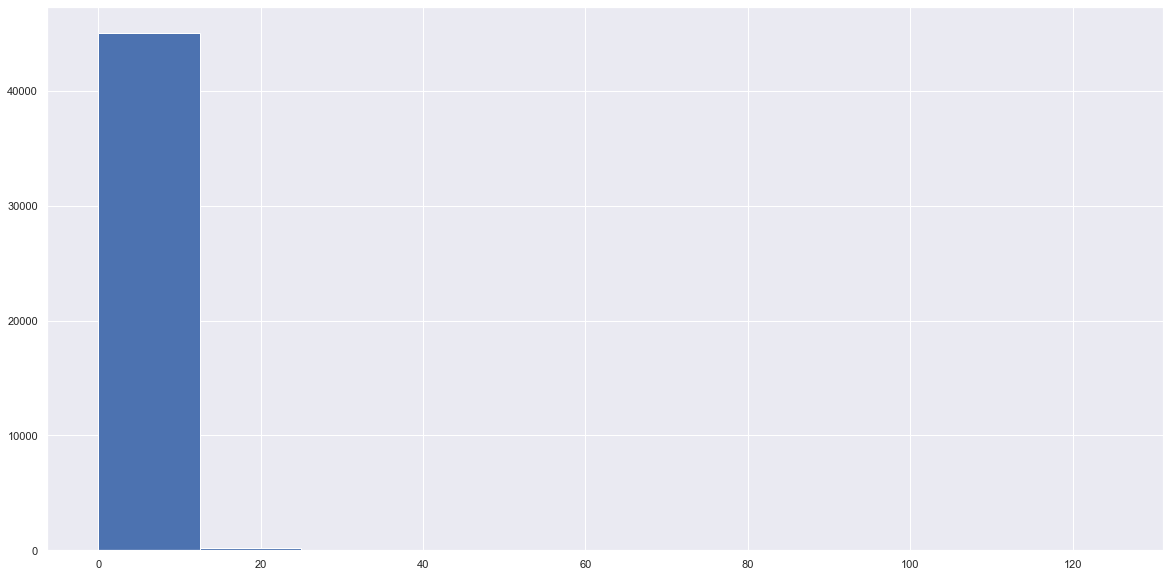

In [21]:
control.user_revenue.hist()
print(stats.shapiro(control.user_revenue.sample(1000, random_state=17)))
print(np.std(control.user_revenue))

ShapiroResult(statistic=0.10272377729415894, pvalue=0.0)
2.8066762535148264


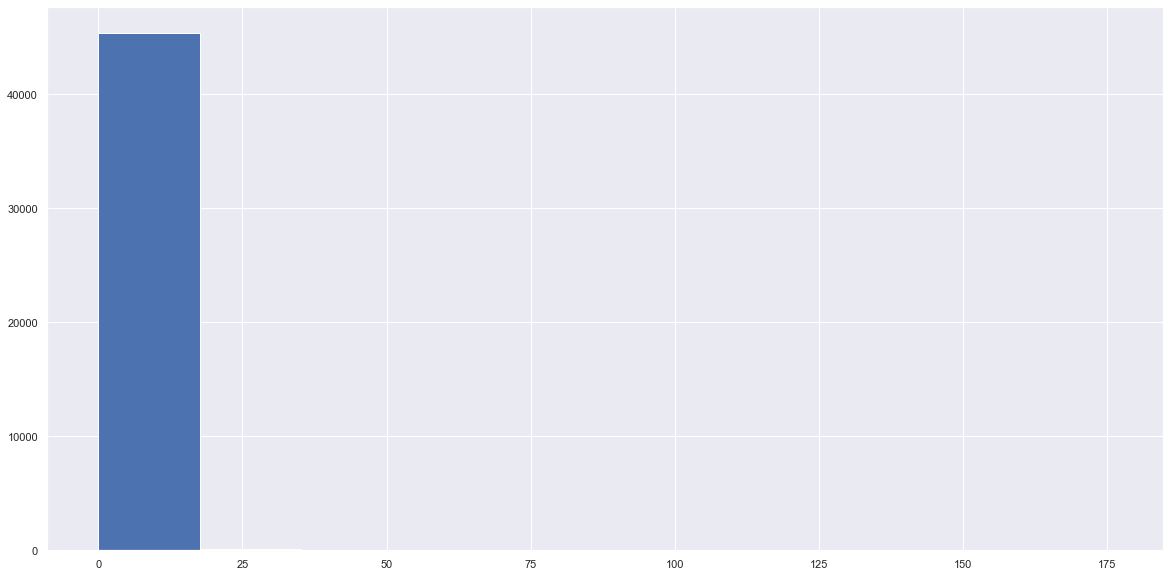

In [22]:
test.user_revenue.hist()
print(stats.shapiro(test.user_revenue.sample(1000, random_state=17)))
print(np.std(test.user_revenue))

В обоих случаях распределения не являются нормальными (p-value < 0.05)

Проверим статистическую значимость различий между группами эксперимента.
Т.к. распределения нормальными не являются, воспользуемся бутстрэпом (он также позволит легко оценить доверительные интервалы):

In [23]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    return {"ci": ci, 
            "p_value": p_value}

#### ARPU:

In [24]:
get_bootstrap(control.user_revenue, test.user_revenue)

  0%|          | 0/2000 [00:00<?, ?it/s]

{'ci':               0
 0.025 -0.015021
 0.975  0.058835,
 'p_value': 0.24496371755664403}

#### ARRPU:

In [25]:
get_bootstrap(control.query('user_revenue > 0').user_revenue, test.query('user_revenue > 0').user_revenue)

  0%|          | 0/2000 [00:00<?, ?it/s]

{'ci':               0
 0.025 -0.522639
 0.975  0.338513,
 'p_value': 0.6805550238334706}

#### Стат.значимой разницы в значениях ARPU и ARPPU не обнаружено.

#### CR:

In [26]:
# для этой цели воспользуемся proportions_ztest
count = np.array([control.query('user_revenue > 0').user_id.nunique(), test.query('user_revenue > 0').user_id.nunique()])
nobs = np.array([control.user_id.nunique(), test.user_id.nunique()])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print('z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

z-stat = 3.303076372302363 
 p-value = 0.0009563033912928121


#### По результатам proportions_ztest обнаружены стат.значимые различия в конверсии контрольной и тестовой групп. 

### Вывод

В целом по эксперименту:
- Суммарная выручка в тестовой группе меньше, чем в контрольной на 5.36%;
- Конверсия в платеж тестовой группы пользователей статистически значимо снизилась на ~7.54% относительно контрольной;
- Стат.значимых различий в значениях ARPU и ARPPU групп не обнаружено.

Можно сделать вывод о неудовлетворительных результатах эксперимента.

In [27]:
metrics_by_groups

group,control,test,diff,percent_diff
users,45400.000000,45600.000000,200.000000,0.44
clients,3489.000000,3243.000000,-246.000000,-7.05
total_user_revenue,17001.593107,16090.426997,-911.166110,-5.36
CR,7.690000,7.110000,-0.580000,-7.54
arpu,0.374484,0.352860,-0.021624,-5.77
arppu,4.872913,4.961587,0.088674,1.82
avg_check,1.412182,1.452366,0.040184,2.85
rep_purch,3.510000,3.420000,-0.090000,-2.56
